In [2]:
import sys
sys.path.append('~/EquiScore')

import pickle
from Train import *
from torch import distributed as dist
import torch.multiprocessing as mp
from utils.dist_utils import *
import utils.utils as utils
import random

from argparse import ArgumentParser,FileType
# from utils.parsing import parse_train_args
parser = ArgumentParser()
# parser.add_argument('--config', type=FileType(mode='r'), default=None)
parser.add_argument('--save_dir', type=str, default='workdir', help='Folder in which to save model and logs')
parser.add_argument('--local_rank', type=int, default = -1,help='local rank for DistributedDataParallel')
parser.add_argument('--save_model', type=str, default = './workdir/official_weight/save_model_screen.pt',help='model for test or restart training')
parser.add_argument('--lmdb_cache', type=str, default='./lmdbs/PDBscreen', help='Folder containing trainging data in lmdb format')
parser.add_argument('--data_path', type=str, default='./EquiScore/data/training_data/PDBscreen', help='Folder containing trainging data')
parser.add_argument('--debug', action='store_true', default=False, help='debug mode for EquiScore')
parser.add_argument('--hot_start', action='store_true', default=False, help='Continue training on the basis of the original please set save_model to continue training')
# Dataset
parser.add_argument('--train_keys', type=str, default='./data/data_splits/screen_model/train_keys.pkl', help='Path of file defining the split')
parser.add_argument('--val_keys', type=str, default='./data/data_splits/screen_model/val_keys.pkl', help='Path of file defining the split')
parser.add_argument('--test_keys', type=str, default='./data/data_splits/screen_model/test_keys.pkl', help='Path of file defining the split')
parser.add_argument('--train_val_mode', type=str, default='uniport_cluster', help='data split mode')
# parser.add_argument('--test_keys', type=str, default='./data/test_keys', help='Path of file defining the split')
# distributed training
parser.add_argument('--ngpu', type=int, default=1, help='Number of gpu for training')
parser.add_argument('--MASTER_ADDR', type=str, default='localhost', help='localhost or ip address')
parser.add_argument('--MASTER_PORT', type=str, default='29505', help='port number')
# Training arguments
parser.add_argument('--epoch', type=int, default=400, help='Number of epochs for training')
parser.add_argument('--seed', type=int, default=42, help='random seed')
parser.add_argument('--loss_fn', type=str, default='cross_entry',\
                    choices=['bce_loss','focal_loss','cross_entry','mse_loss','poly_loss_ce','poly_loss_fl'], help='loss function')
parser.add_argument('--grad_sum', type=int, default=1, help='Number of grad accumulation steps')
parser.add_argument('--label_smothing', type=float, default=0.0, help='label smothing coefficient')
parser.add_argument('--eps', type=float, default=4.0, help='focal loss eps')
parser.add_argument('--batch_size', type=int, default=64, help='Batch size on each gpu')
parser.add_argument('--sampler', action='store_true', default=False, help='dynamic sampler or not')
parser.add_argument('--scheduler', type=str, default=None, help='LR scheduler')
parser.add_argument('--patience', type=int, default=50, help='Patience of early stopping')
parser.add_argument('--lr', type=float, default=0.0001, help='Initial learning rate')
parser.add_argument('--lr_decay', action='store_true', default=True, help='dynamic sampler or not')
parser.add_argument('--max_lr', type=float, default=0.001, help='max learning rate') 
parser.add_argument('--pct_start', type=float, default=0.3, help='OneCycleLR parameter')
parser.add_argument('--num_workers', type=int, default=8, help='Number of workers for preprocessing')
# Model
parser.add_argument('--model', type=str, default='EquiScore', help='model class')
parser.add_argument('--pred_mode', type=str, default='ligand', help='prediction mode')
parser.add_argument('--n_graph_layer', type=int, default=2, help='Number of EquiScore layers')
parser.add_argument('--threshold', type=float, default=5.5, help='Radius cutoff for geometric diatance based graph')
parser.add_argument('--n_FC_layer', type=int, default=4, help='Number of linear layers')
parser.add_argument('--d_FC_layer', type=int, default=256, help='dims of linear layers')
parser.add_argument('--n_in_feature', type=int, default=128, help='dims of input features in EquiScore')
parser.add_argument('--n_out_feature', type=int, default=128, help='dims of output features in EquiScore')
parser.add_argument('--ffn_size', type=int, default=280, help='dims of FFN layers in EquiScore')
parser.add_argument('--dropout_rate', type=float, default=0.1, help='dropout_rate in EquiScore')
parser.add_argument('--attention_dropout_rate', type=float, default=0.1, help='dropout_rate in Attention module')
parser.add_argument('--head_size', type=int, default=8, help='number of attention heads in EquiScore')
parser.add_argument('--pos_enc_dim', type=int, default=16, help='position encoding dims')
parser.add_argument('--edge_dim', type=int, default=64, help='edge feature dims')
parser.add_argument('--layer_norm', action='store_true', default=True, help='layer_norm or not')
parser.add_argument('--graph_norm', action='store_true', default=True, help='graph_norm or not')
parser.add_argument('--residual', action='store_true', default=True, help='residual or not')
parser.add_argument('--edge_bias', action='store_true', default=True, help='covalent bond informations')
parser.add_argument('--rel_3d_pos_bias', action='store_true', default=True, help='3d distance informations')
parser.add_argument('--in_degree_bias', action='store_true', default=True, help='indegree infomations')
parser.add_argument('--virtual_aromatic_atom', action='store_true', default=True, help='add virtual aromatic atom')
parser.add_argument('--fingerprintEdge', action='store_true', default=True, help='construct edge based fingerprint information by proLIF ')
parser.add_argument('--FP', action='store_true', default=True, help='use AttentiveFP feature or graphformer feature')
parser.add_argument('--rel_pos_bias', action='store_true', default=False, help=' shortest path distance informations')
parser.add_argument('--lap_pos_enc', action='store_true', default=False, help='laplace position infomations')
# Benchmark test and Screen compounds for a target protein
parser.add_argument('--test', action='store_true', default=False, help='test mode for banchmark test or screen compounds')
parser.add_argument('--test_mode', type = str,default='one_pose', choices=['one_pose','multi_pose'],help="if docking result one pose for a ligand set 'one_pose' or multi poses for a ligand set multi_pose")
parser.add_argument('--test_flag', type = str,default='external_test',help="anything can help you to identify the test result")
parser.add_argument('--idx_style', action='store_true', default=False, help='for multi_pose mode to select multi pose test or one pose test in the pose number')
parser.add_argument('--pose_num', type=int, default=1, \
                    help='select the pose number for multi_pose mode test ,for example : \
                        if pose_num = 3, idx_style=true, just the 3rd pose for test,\
                        but if idx_style=false, the first 3 poses will be test')
parser.add_argument('--test_path', type=str, default="./data/sample_data/", \
                    help='test directory which contains the banchmark test data dirs')
parser.add_argument('--test_name', type=str, default="tmp_pockets", \
                    help='test dataset directory which contains the test pockets')
parser.add_argument('--EF_rates', type=list, default=[0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5], \
                    help='EF rates for banchmark test')
parser.add_argument('--pred_save_path', type=str, default="./data/test_results/EquiScore_pred_for_tmp_pockets.pkl", \
                    help='path for prediction results in Screening script')
args = parser.parse_args([])
# in notebook you should add a '[]' to  args = parser.parse_args() in parse_train_args function
seed_torch(seed = args.seed)
args.ngpu = 1

In [3]:
# select keys to compute 
def getDataLoader(args,key_type= 'active',nums = 10000):
    try:
        with open (args.test_keys, 'rb') as fp:
            keys = pickle.load(fp)
    except:
        keys = args.test_keys
    test_actives = [i for i in keys if '_active'  in i.split('/')[-1] ]
    test_decoys = [i for i in keys if '_active' not in i.split('/')[-1]]
    all_pocket =  test_actives + test_decoys 
    random.shuffle(all_pocket)
    random.shuffle(test_actives)
    random.shuffle(test_decoys)
    
    print(f'actives num : {len(test_actives)} decoys num : {len(test_decoys)}')
    if key_type== 'active':
        test_keys = test_actives[:nums]
    elif key_type== 'decoy' :
        test_keys = test_decoys[:nums]
    else:
        test_keys = all_pocket[:nums]
        
    test_dataset = ESDataset(test_keys,args, args.data_path,args.debug)
    test_sampler = SequentialDistributedSampler(test_dataset,1) if args.ngpu > 1 else None
    test_dataloader = DataLoaderX(test_dataset, 1, sampler=test_sampler,prefetch_factor = 4,\
        shuffle=False, num_workers = 1, collate_fn=test_dataset.collate,pin_memory=True) 
    return test_sampler,test_dataloader,test_keys

In [4]:
def getModel(args):
    if args.FP:
        args.N_atom_features = 39
    else:
        args.N_atom_features = 28
    #hyper parameters
    num_epochs = args.epoch
    lr = args.lr
    ngpu = 1
    args.ngpu = 1
    batch_size = args.batch_size = 1
    data_path = args.data_path
    save_dir = args.save_dir
    train_time = time.strftime('%Y-%m-%d-%H-%M-%S')
    #make save dir if it doesn't exist
    #initialize model
    if args.ngpu>0:
        cmd = get_available_gpu(num_gpu=args.ngpu, min_memory=8000, sample=3, nitro_restriction=False, verbose=True)

        if cmd[-1] == ',':
            os.environ['CUDA_VISIBLE_DEVICES']=cmd[:-1]
        else:
            os.environ['CUDA_VISIBLE_DEVICES']=cmd
        print(cmd)
    model = EquiScore(args) if args.model == 'EquiScore' else None
    print ('number of parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))
    args.device = 'cuda:0'
    args.local_rank = 'cuda:0'
    model ,opt_dict,epoch_start= utils.initialize_model(model, args.device,args,args.save_model)
    return model


In [5]:
'''
util funcs

'''
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dgl.nn.functional import edge_softmax
def MeanStd(data):
    max_value = max(data)
    min_value = min(data)
    X_std = (data - min_value)/((max_value-min_value) + 1e-11)
    X_scaled  =  X_std*(max_value - min_value) + min_value
    return X_scaled/X_scaled.sum()
def MaxMin(atom_weights):
    min_value = min(atom_weights)
    max_value = max(atom_weights)
    atom_weights = (atom_weights - min_value) / (max_value - min_value)
    return atom_weights
def plotAttDist(pred_g):
    score = edge_softmax(graph = pred_g,logits = pred_g.edata['score'])
    atts = score.squeeze(-1).mean(1)
    plt.plot(atts)
def copyAtt(pred_g):
    atts_copy = np.zeros(shape = (len(pred_g.nodes()),len(pred_g.nodes())))
    u,v = pred_g.edges()
    eids = pred_g.edge_ids(u,v)
    atts_copy[u,v]= atts[eids]
    return atts_copy
def getAttnFP(pred_g,fp,n1):
    '''
    get IFP edge attentions and covalent edges attentions
    '''
    # atompairs = fp
    temp_fp= np.array(fp)
    u,v = list(temp_fp[:,0]) +  list((n1+ temp_fp[:,1])),list((n1+ temp_fp[:,1])) + list(temp_fp[:,0])
    eids = pred_g.edge_ids(u,v)
    # all_ids = pred_g.num_
    all_ids = list(range(pred_g.num_edges()))
    eid_res = torch.tensor(list(set(all_ids) - set(eids.data.cpu().numpy()))).to(eids.device)
    
    # score = edge_softmax(graph = pred_g,logits = pred_g.edata['score'].squeeze(-1).mean(1).clamp(-5,5))
    score = edge_softmax(graph = pred_g,logits = pred_g.edata['score'].clamp(-5,5))
#     atts = pred_g.edata['score'].squeeze(-1).mean(1)
    attnFP = score[eids]
    attnCovalent = score[eid_res]
    return attnFP,attnCovalent


In [6]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import SimilarityMaps
import  rdkit.Chem.AllChem as AllChem
IPythonConsole.ipython_useSVG = True
import copy
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from IPython.display import display
import matplotlib
import matplotlib.cm as cm
def InchMap(mol):
    inchi, aux_info = Chem.MolToInchiAndAuxInfo(mol)
    for i in aux_info.split('/'):
        if i[0]=='N':
            pos=i[2:].split(',')
    inchi_to_mol = {i:int(j)-1 for i,j in enumerate(pos)}
    mol_to_inchi = {int(j)-1 :i for i,j in enumerate(pos)}
    return inchi_to_mol,mol_to_inchi
def mol_with_atom_weight( mol ,weights,mol_to_inchi):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp("atomNote", f"{str( round(float(weights[mol_to_inchi[mol.GetAtomWithIdx( idx ).GetIdx()]]),3))}")
    return mol

In [7]:
# create plot atom level highlight fig functions 

def drawmol(mol_3d,atom_weights,flag = '',idx_to_plot = 0):
    inchi_to_mol,mol_to_inchi = InchMap(mol_3d)
    weight_inchi = []
    for i in range(len(atom_weights)):
        try:
            weight_inchi.append(atom_weights[inchi_to_mol[i]])
        except:
            weight_inchi.append(atom_weights[i])
                                        
    mol_2d = Chem.MolFromSmiles(Chem.MolToSmiles(mol_3d))
    inchi_smiles_to_mol,mol_smiles_to_inchi = InchMap(mol_2d)
    idx_to_plot = inchi_smiles_to_mol[mol_to_inchi[idx_to_plot]]

    
    weight_inchi = MaxMin(weight_inchi)
    
    note =flag
    #############  not add virtual node weight info ###############
    # note =flag +  '  Virtual Node weight:'
    # for i in range(len(mol_3d.GetAtoms()),len(weight_inchi)):
    #     note += f' {i} : {round(weight_inchi[i],3)} '
    # note += f' highlight aromatic ring No.{idx_virtual}'
    #     # print(note)
    ###########################################################
        

    mol_2d = mol_with_atom_weight( mol_2d ,weight_inchi,mol_to_inchi)
    
    norm = matplotlib.colors.Normalize(vmin=-1.0, vmax=1.28) 
    cmap = cm.get_cmap('bwr')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i:  plt_colors.to_rgba(float(mol_2d.GetAtomWithIdx( idx_to_plot ).GetProp("atomNote")))  }
 
    rdDepictor.Compute2DCoords(mol_2d)
    drawer = rdMolDraw2D.MolDraw2DSVG(512, 512)
    drawer.SetFontSize(20)
    op = drawer.drawOptions()
     
    mol = rdMolDraw2D.PrepareMolForDrawing(mol_2d)
    drawer.DrawMolecule(mol_2d, highlightAtoms=[idx_to_plot],
                             highlightBonds=[],
                             highlightAtomColors=atom_colors,legend = note)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:', '')
    return (mol_2d, weight_inchi, svg,idx_to_plot)

In [8]:
# create plot substructure level highlight fig functions 

def drawmolVirtualNode(mol_3d,atom_weights,idx_virtual,flag = '',idx_to_plot = []):
    inchi_to_mol,mol_to_inchi = InchMap(mol_3d)
    weight_inchi = []
    for i in range(len(atom_weights)):
        try:
            weight_inchi.append(atom_weights[inchi_to_mol[i]])
        except:
            weight_inchi.append(atom_weights[i])
                                        
    mol_2d = Chem.MolFromSmiles(Chem.MolToSmiles(mol_3d))
    ################
    inchi_smiles_to_mol,mol_smiles_to_inchi = InchMap(mol_2d)
    idx_to_plot = [inchi_smiles_to_mol[mol_to_inchi[i]] for i in idx_to_plot ]
    weight_inchi = MaxMin(weight_inchi)
    note =flag
    #############  not add virtual node weight info###############
    note =flag +  '  Virtual Node weight:'
    for i in range(len(mol_3d.GetAtoms()),len(weight_inchi)):
        note += f' {i} : {round(weight_inchi[i],3)} '
    note += f' highlight aromatic ring No.{idx_virtual}'
    #     # print(note)
    ###########################################################

    mol_2d = mol_with_atom_weight( mol_2d ,weight_inchi,mol_to_inchi)
    
    
    norm = matplotlib.colors.Normalize(vmin=-1.0, vmax=1.28) 
    cmap = cm.get_cmap('bwr')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i: plt_colors.to_rgba(float(mol_2d.GetAtomWithIdx( idx ).GetProp("atomNote"))) for idx in idx_to_plot}
 
    rdDepictor.Compute2DCoords(mol_2d)
    drawer = rdMolDraw2D.MolDraw2DSVG(512, 512)
    drawer.SetFontSize(20)
    op = drawer.drawOptions()
     
    mol = rdMolDraw2D.PrepareMolForDrawing(mol_2d)
    drawer.DrawMolecule(mol_2d, highlightAtoms=idx_to_plot,
                             highlightBonds=[],
                             highlightAtomColors=atom_colors,legend = note)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:', '')
    return (mol_2d, weight_inchi, svg,idx_to_plot)

In [9]:

import pickle 
from utils.equiscore_utils import *
import utils.dataset_utils as dataset_utils
from tqdm import tqdm
from cairosvg import svg2png
def save_PNG(model,h,mol,pred_g,logit,key,g,save_dir):
    logit = F.softmax(logit,dim = 1)[:,1].data.cpu().numpy()[0]
    ligand_num = int(pred_g.ndata['V'].sum().data.cpu().numpy())
    for module in model.weight_and_sum.atom_weighting:
        h = module(h)

    for idx in range(len(mol.GetAtoms())):
        mol_2d, aw, svg,inchi_idx = drawmol(mol, h.flatten().data.cpu().numpy()[:ligand_num],flag = ' prob: ' + '%.4f'%logit,idx_to_plot = idx) 
        save_path = os.path.join(*[save_dir,os.path.join(*key.split('/')[-2:-1])]) 

        os.makedirs(save_path, exist_ok=True)
        svg2png(bytestring=svg,dpi=600,write_to=os.path.join(save_path,key.split('/')[-1] + '_atom_idx_{}_{}.png'.format(inchi_idx,'%.4f'%logit)))
    for idx in range(len(mol.GetAtoms()),ligand_num):
        negs = g.in_edges(idx)[0].data.cpu().numpy().tolist()
        negs = [i for i in negs if i !=idx]

        mol_2d, aw, svg,inchi_idx = drawmolVirtualNode(mol, h.flatten().data.cpu().numpy()[:ligand_num],idx,flag = ' prob: ' + '%.4f'%logit,idx_to_plot = negs) 
        save_path = os.path.join(*[save_dir,os.path.join(*key.split('/')[-2:-1])]) 

        os.makedirs(save_path, exist_ok=True)
        svg2png(bytestring=svg,dpi=660,write_to=os.path.join(save_path,key.split('/')[-1] + '_virtual_node_{}_{}.png'.format(idx,'%.4f'%logit)))  
def getResult(model,test_sampler,test_dataloader,test_keys,save_dir):
    logits = []
    gs = []
    none_fp  = 0
    model.eval()
    pbar = tqdm(test_dataloader)
    with torch.no_grad():
        test_losses,test_true,test_pred = [], [],[]
        for i_batch, (g,full_g,Y) in enumerate(pbar):
            key = test_keys[i_batch]
            # get fp idx
            with open(key,'rb') as f:
                m1,m2,atompairs,types = pickle.load(f)

                f.close()
            n1,d1,adj1 = dataset_utils.get_mol_info(m1)
            n2,d2,adj2 = dataset_utils.get_mol_info(m2)
            H1 = get_atom_graphformer_feature(m1,FP = args.FP)
            if args.virtual_aromatic_atom:
                adj1,H1,d1,n1 = dataset_utils.add_atom_to_mol(m1,adj1,H1,d1,n1)

            ################## ##############################
            model.zero_grad()
            g = g.to(args.local_rank)
            full_g = full_g.to(args.local_rank)
            Y = Y.long().to(args.local_rank)
            h,pred_g,pred_full_g,logit = model.getAtt(g,full_g) 
            logits.append(logit)
            # save png
            if F.softmax(logit,dim = 1)[:,1].data.cpu().numpy()[0] > 0.0:
                save_PNG(model,h,m1,pred_g,logit,key,g,save_dir = save_dir)
            
            gs.append((pred_g,pred_full_g,m1,m2))
            pbar.set_description('fp num : {}-- ration : {}/{}'.format(none_fp,i_batch + 1,len(test_dataloader)))
    return logits,gs


In [10]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
import matplotlib.image as mpimg
def pltStarWeightMap(G,weightmap_dir,save_dir,with_labels = True):
    plt.figure(figsize = (24,10))
    plt.subplot(121)
    pos = nx.spring_layout(G, seed=63)  # Seed layout for reproducibility
    num_nodes = G.number_of_nodes()
    colors  = nx.get_edge_attributes(G,'weight').values()
    options = {
        "node_color": ['#F66D44']+["#A0CBE6"]*(num_nodes -1),
        "edge_color": colors,
        "width": 4,
        "edge_cmap": plt.cm.Greens,
        "with_labels": with_labels,
    }
    nx.draw(G, pos, **options)
    plt.subplot(122)
    lena = mpimg.imread(weightmap_dir)
    plt.imshow(lena)
    plt.axis('off')
    # plt.show()
    plt.savefig(os.path.join(save_dir,weightmap_dir.split('/')[-1]),dpi=660,format='png')
def pltStarWeightMapVirtualNode(G,save_dir,idx,key,with_labels = True):
    plt.figure(figsize = (12,10))
    pos = nx.spring_layout(G, seed=63)  # Seed layout for reproducibility
    num_nodes = G.number_of_nodes()
    colors  = nx.get_edge_attributes(G,'weight').values()
    options = {
        "node_color": ['#F66D44']+["#A0CBE6"]*(num_nodes -1),
        "edge_color": colors,
        "width": 4,
        "edge_cmap": plt.cm.Greens,
        "with_labels": with_labels,
    }
    nx.draw(G, pos, **options)
    plt.axis('off')
    # plt.show()
    plt.savefig(os.path.join(save_dir,key.split('/')[-1]+'_%d_virtual_node.png'%idx),dpi=660,format='png')

In [11]:

import glob
save_dir = './figures/fep1_atom_interaction_weight/'

keys = glob.glob('your data set path should be in here/*')
keys = [key for key in keys if 'ptp1b_23485' in key.lower()]
args.test_keys = keys
args.test = True
args.save_model = './workdir/official_weight/save_model_LeadOpt.pt'
test_sampler,test_dataloader,test_keys = getDataLoader(args,key_type= 'all',nums = 5000)
model = getModel(args)
logits,gs= getResult(model,test_sampler,test_dataloader,test_keys,save_dir = save_dir)

actives num : 0 decoys num : 1
Available GPU List
id	utilization.gpu(%)	memory.free(MiB)
1 	35                	9057            
4 	38                	8259            
7 	21                	8196            
Select id #7 for you.
7
number of parameters :  565317
load save model!


  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_84385/3258704081.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bwr')
/tmp/ipykernel_84385/969974910.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bwr')
fp num : 0-- ration : 1/1: 100%|██████████| 1/1 [00:05<00:00,  5.26s/it]


/tmp/ipykernel_84385/638016884.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (24,10))


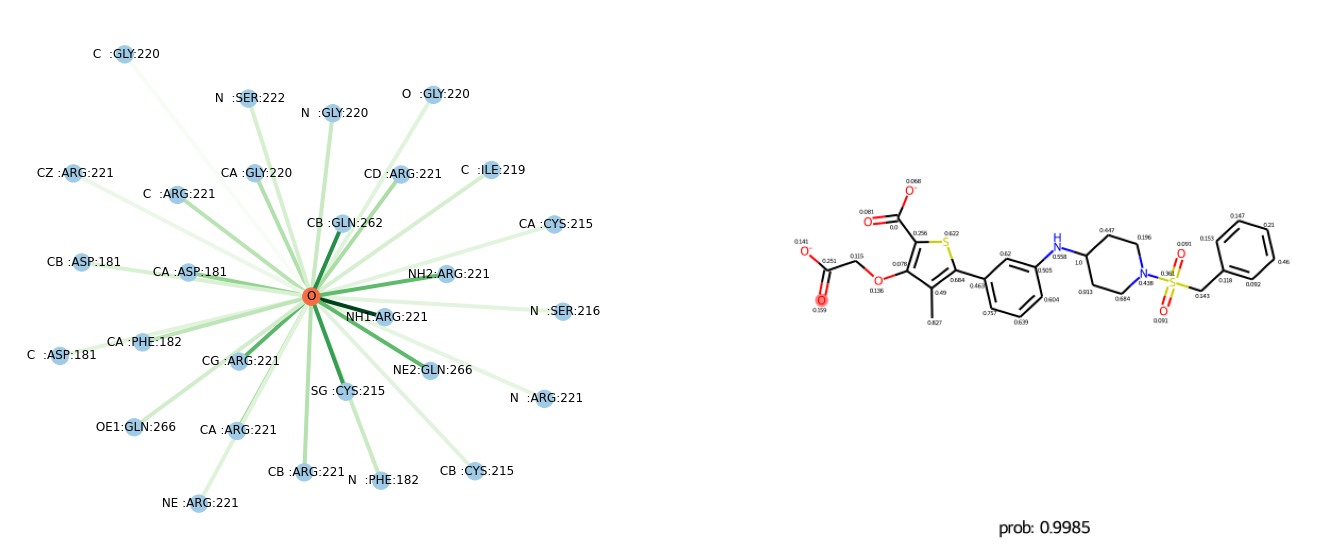

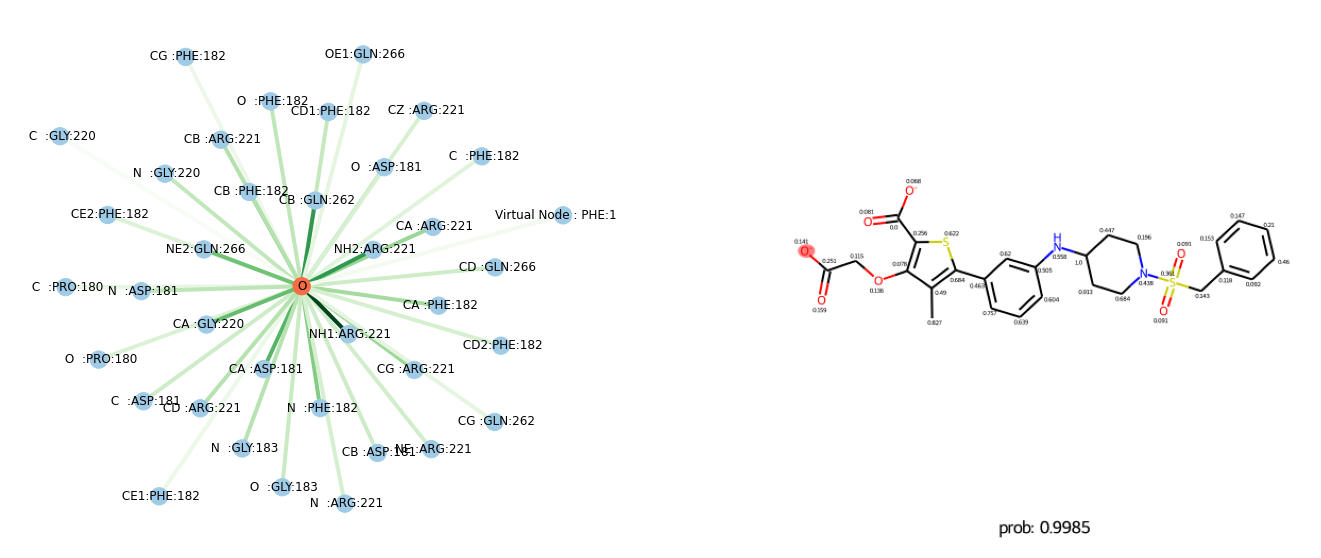

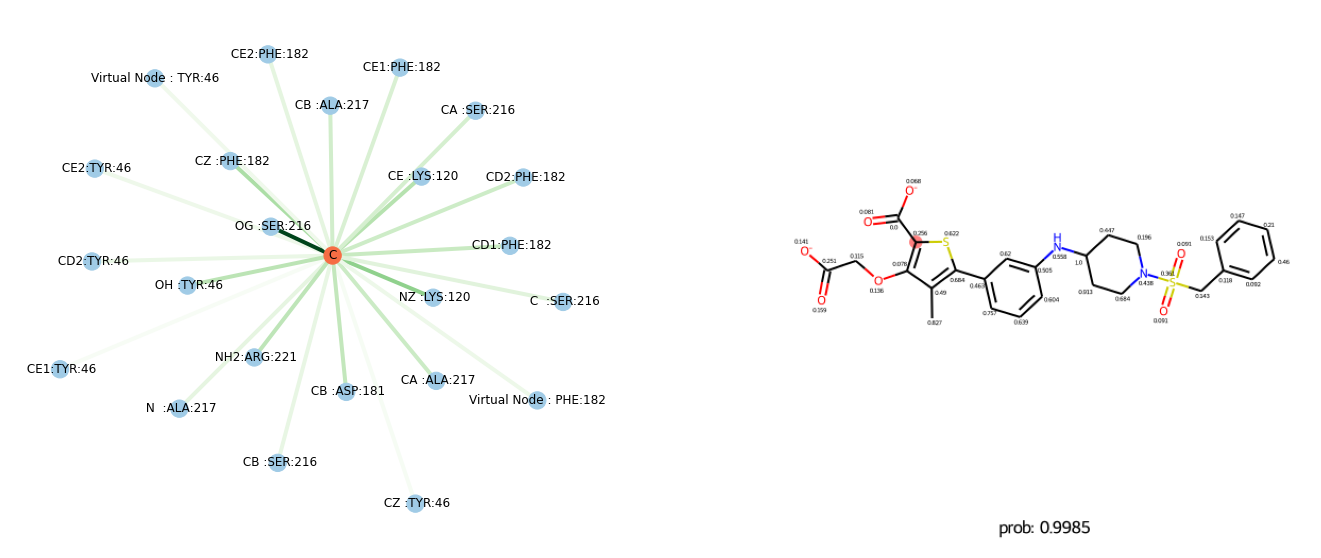

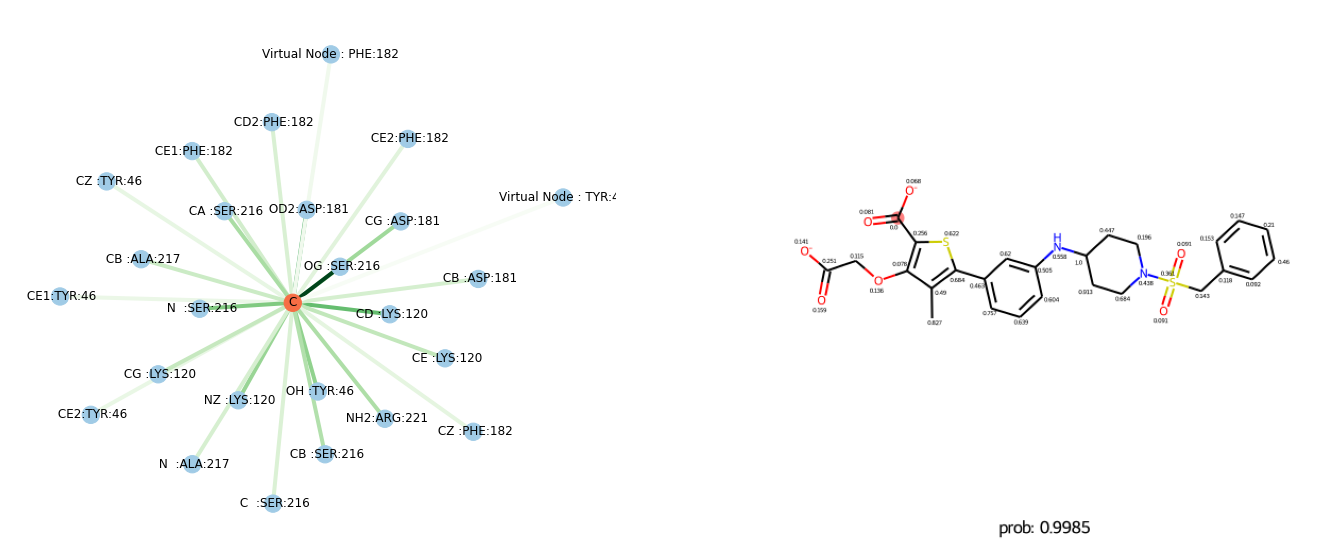

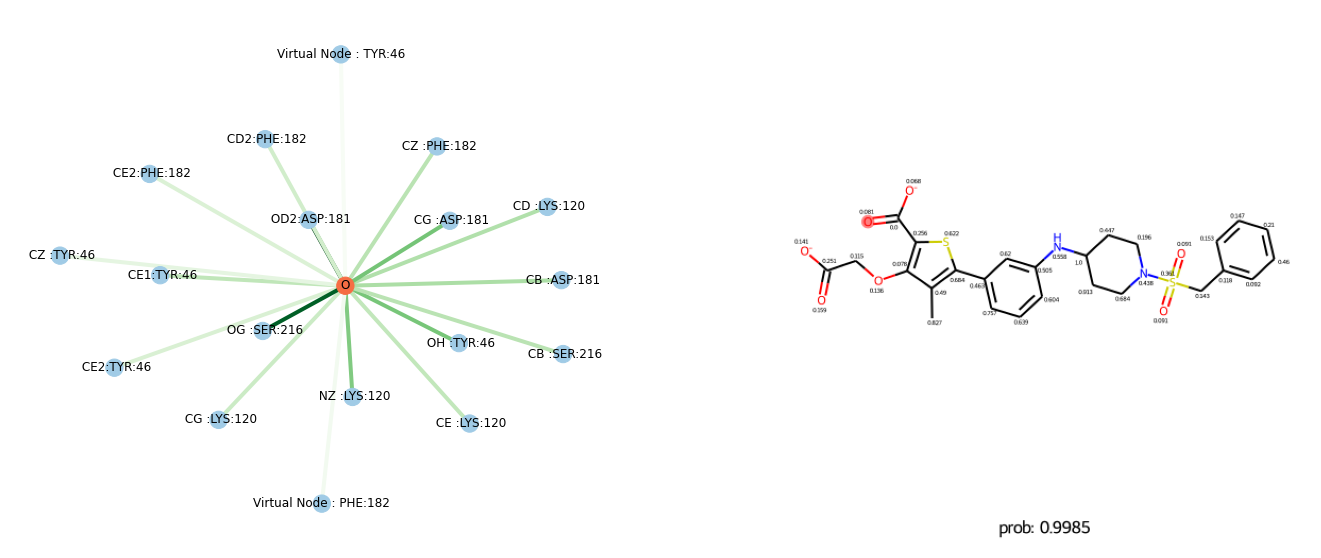

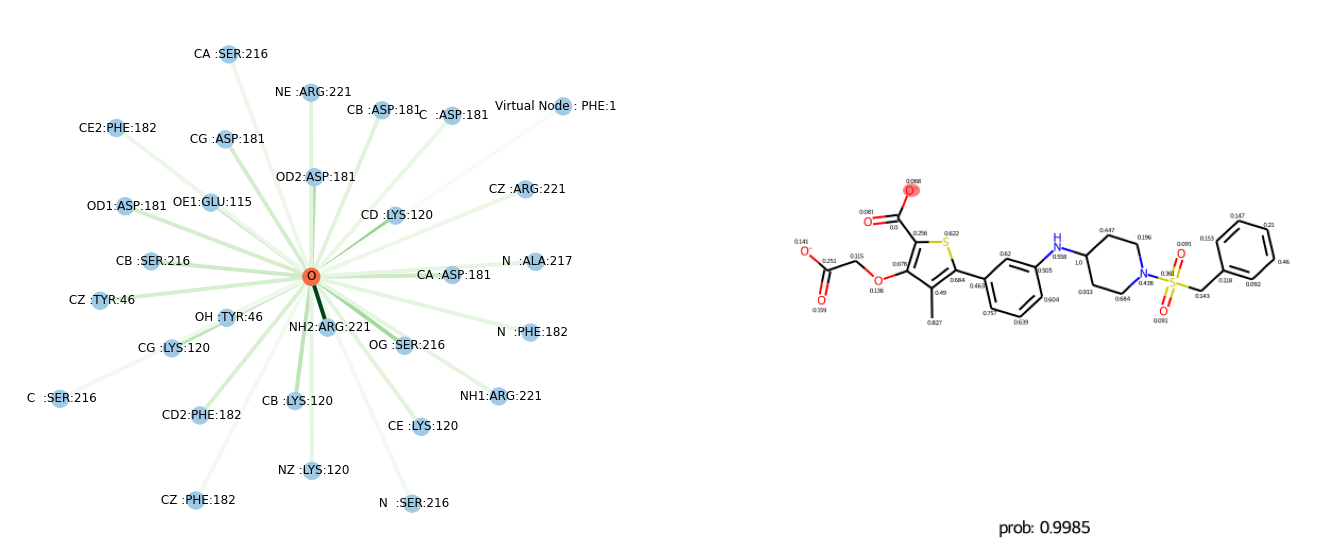

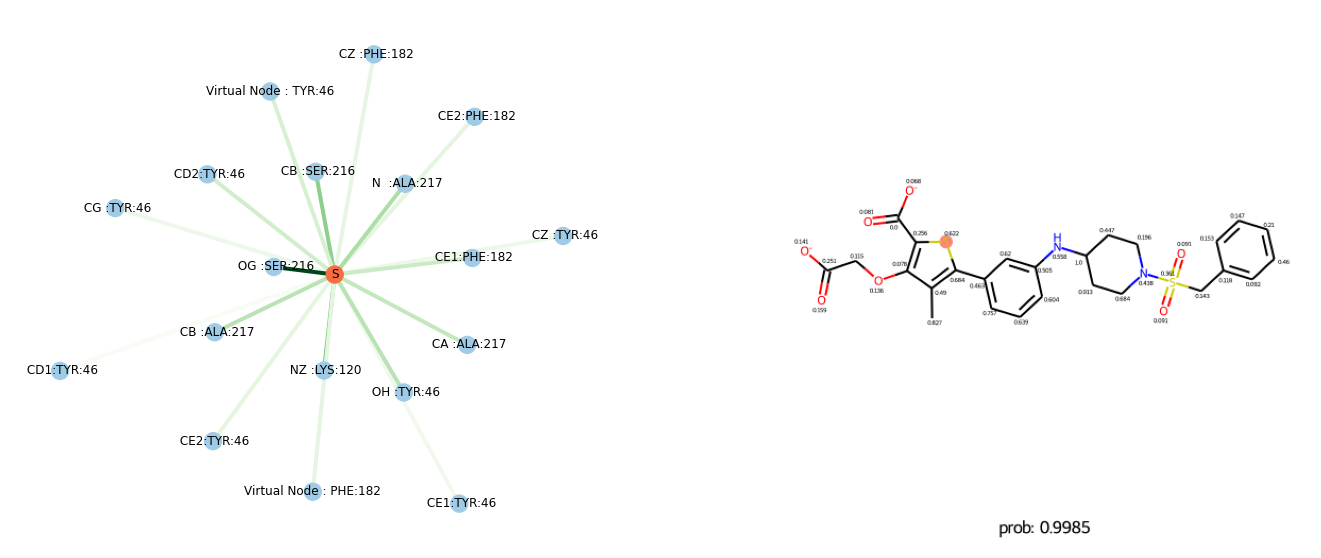

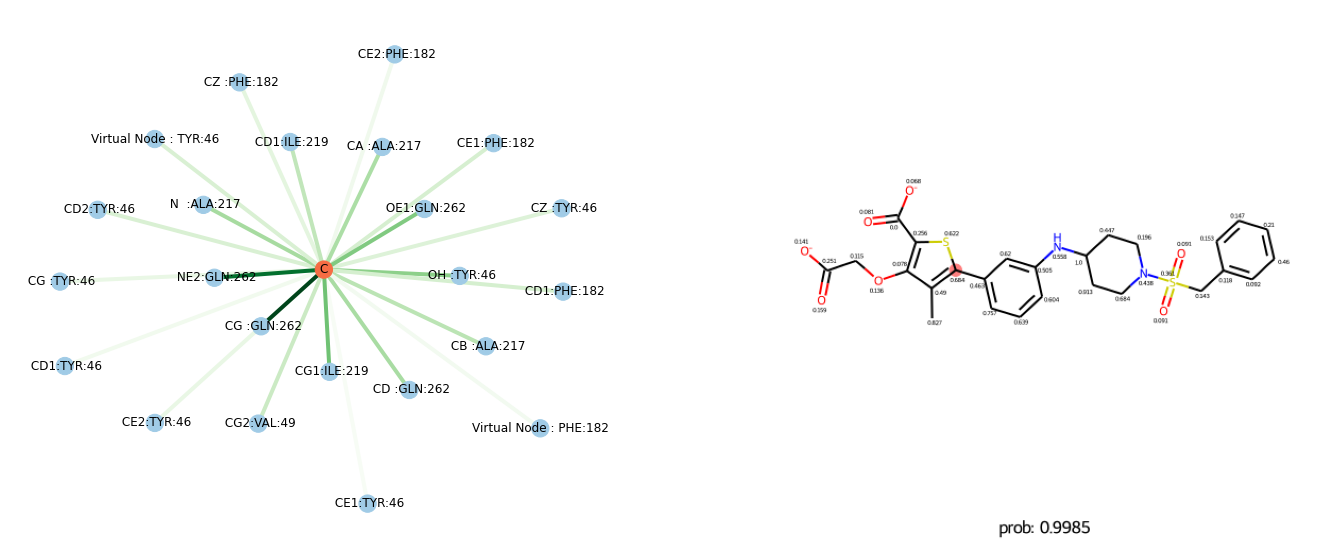

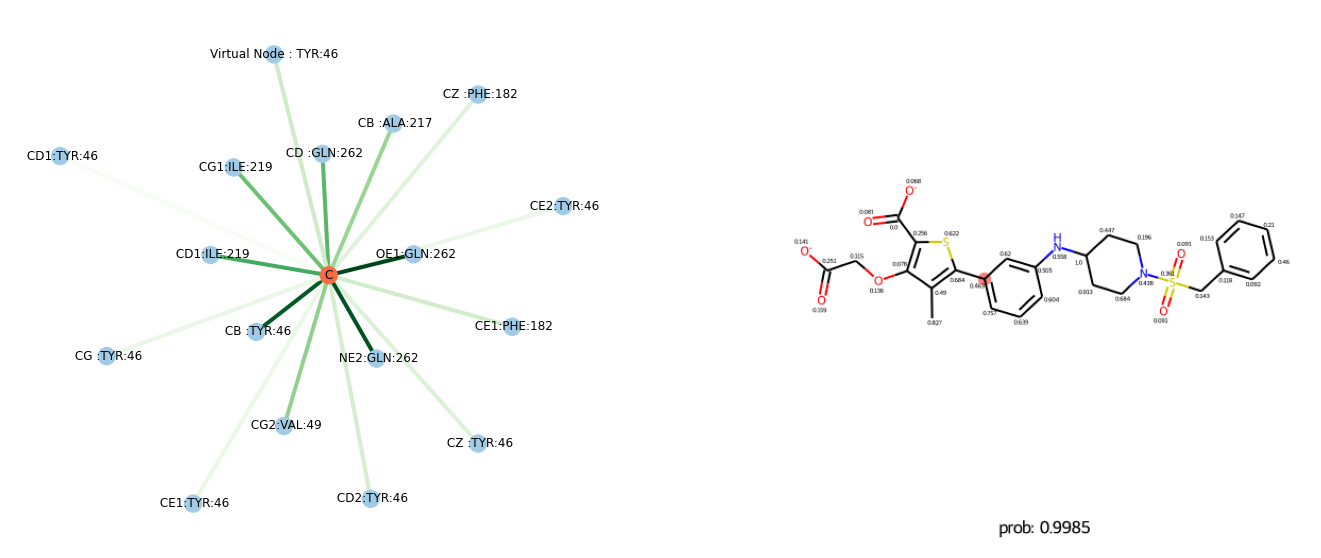

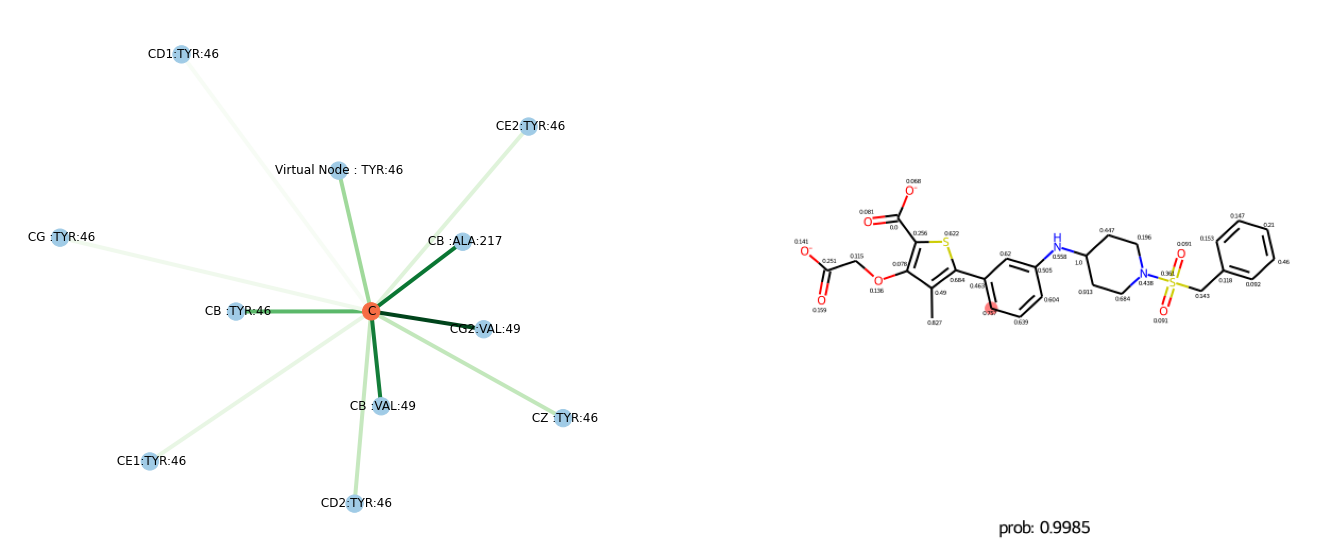

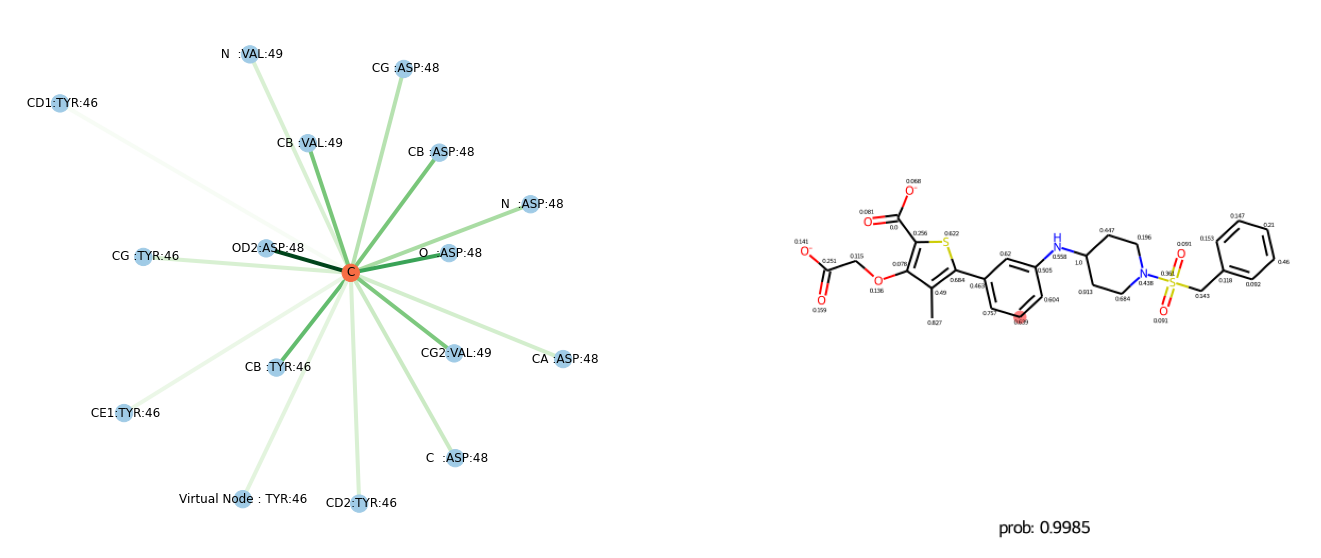

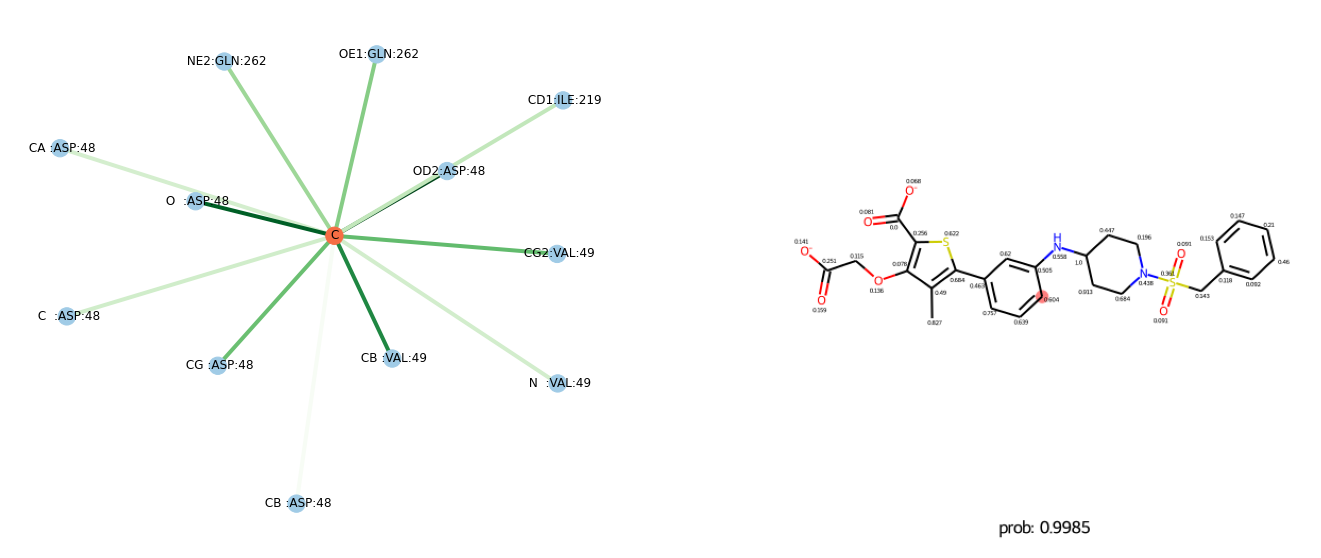

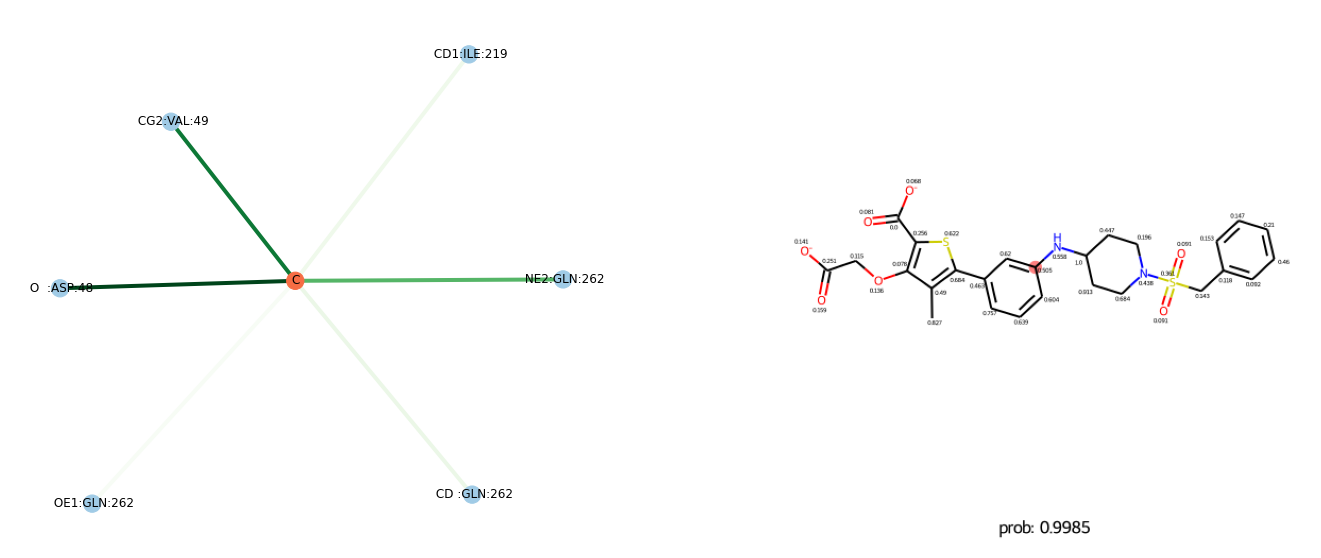

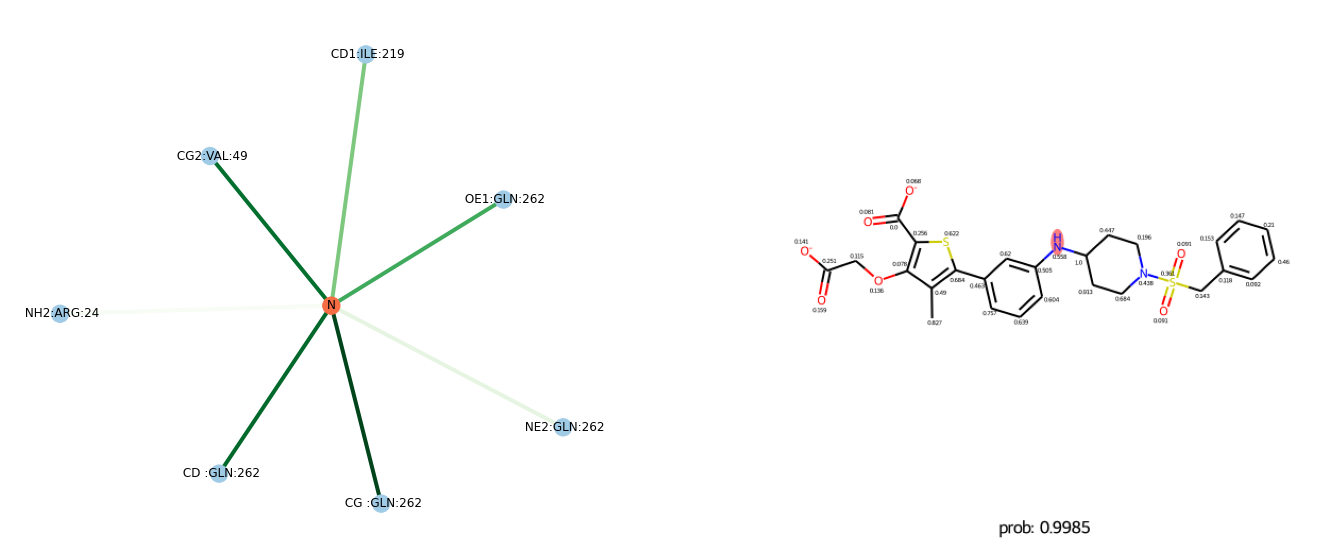

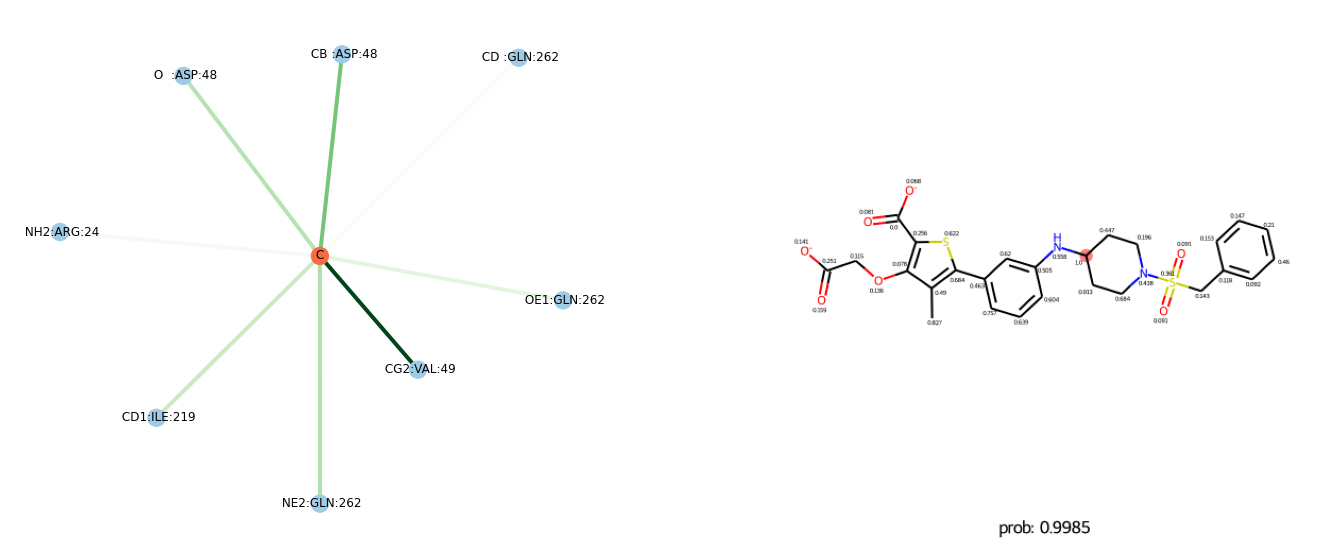

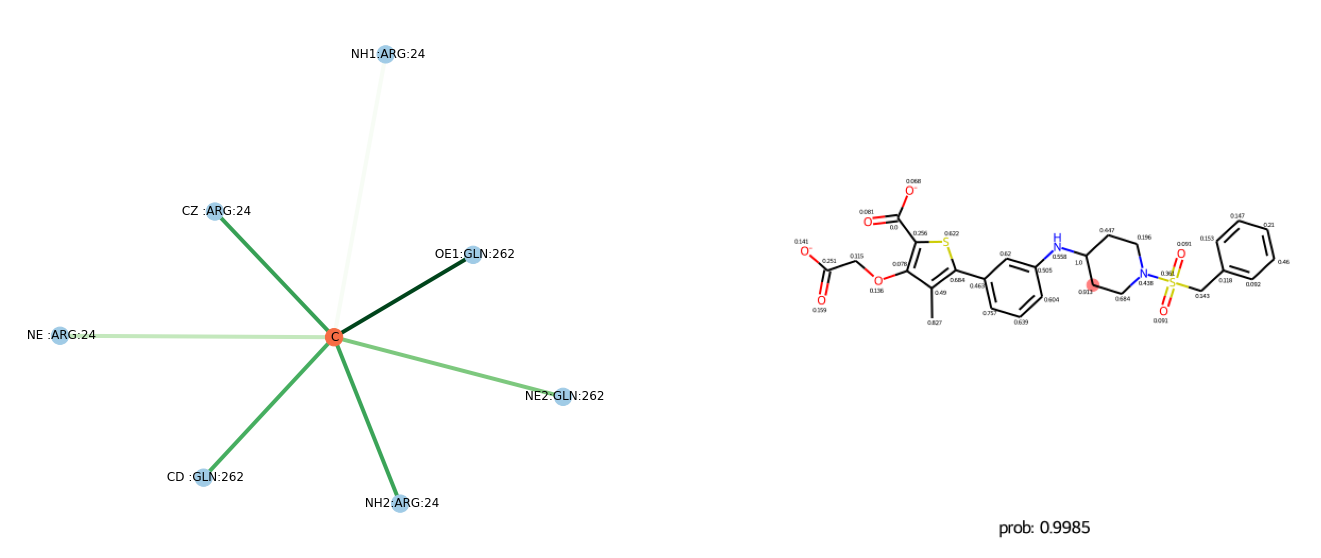

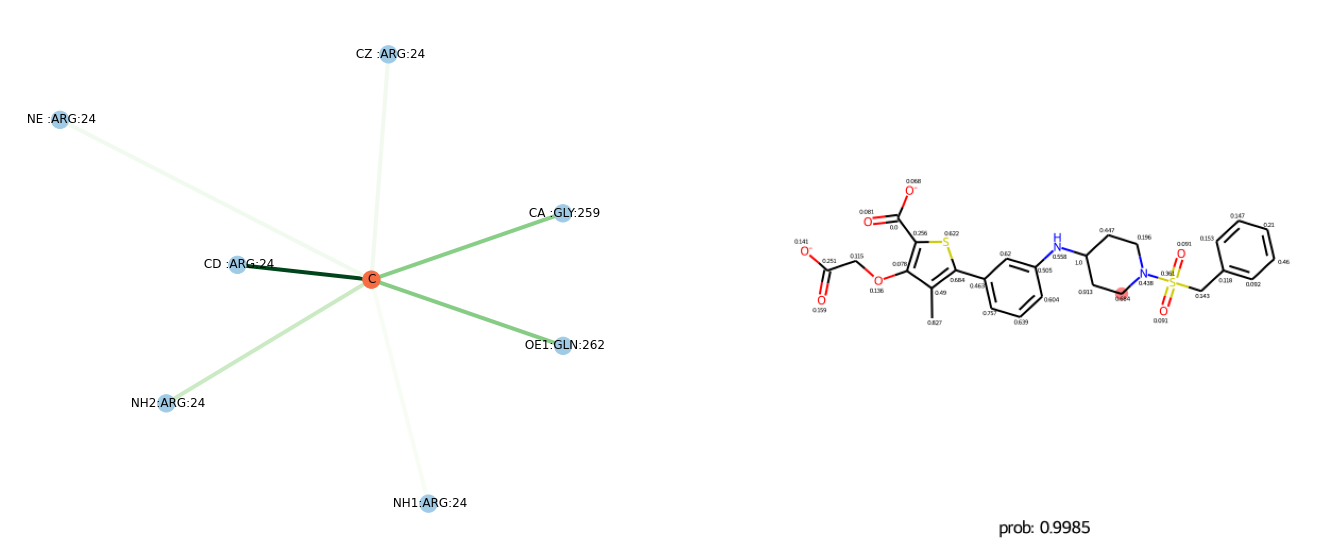

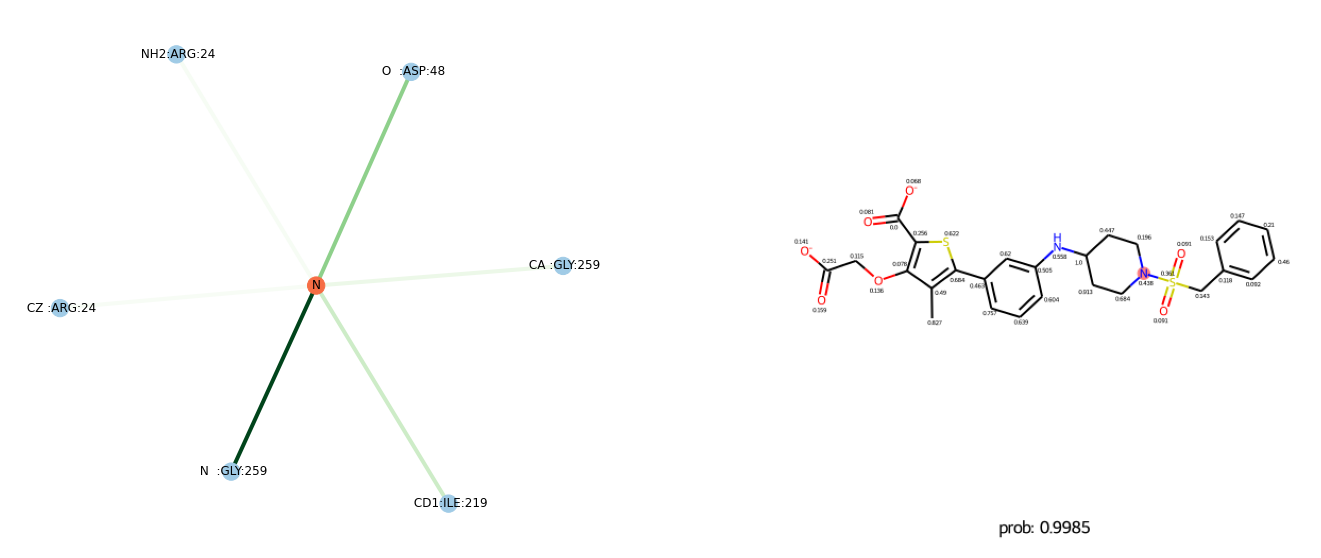

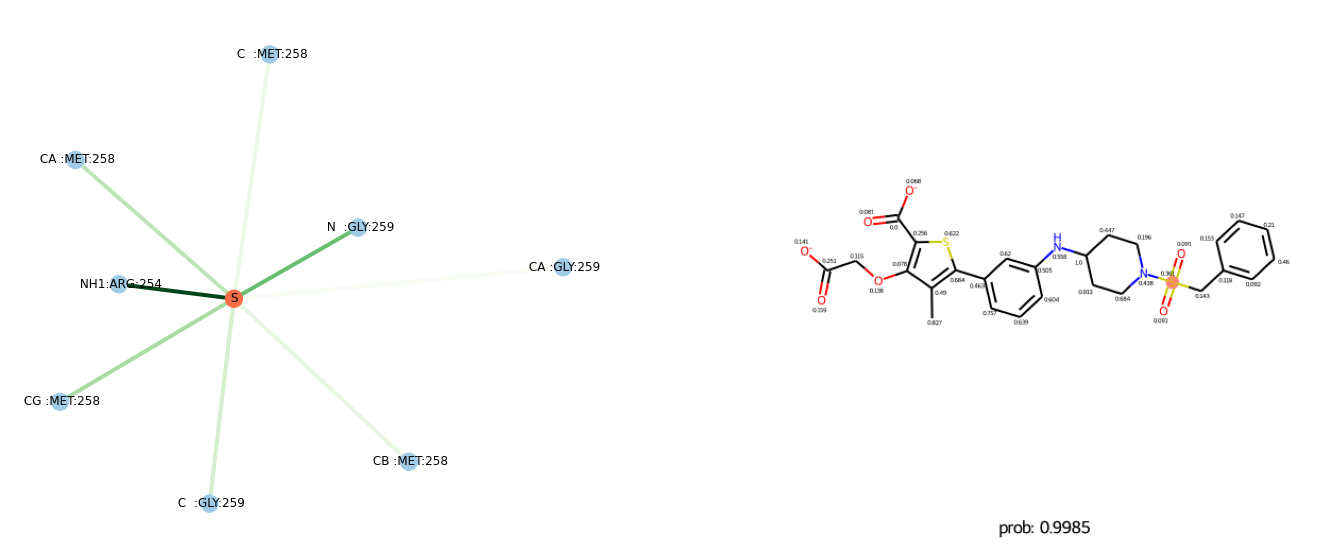

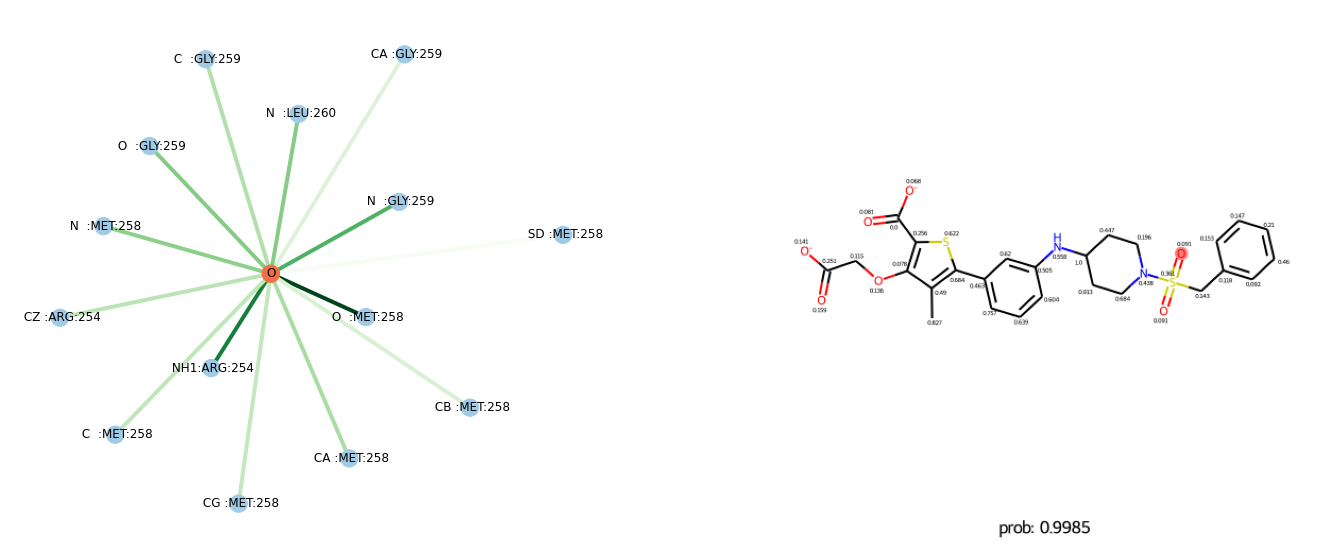

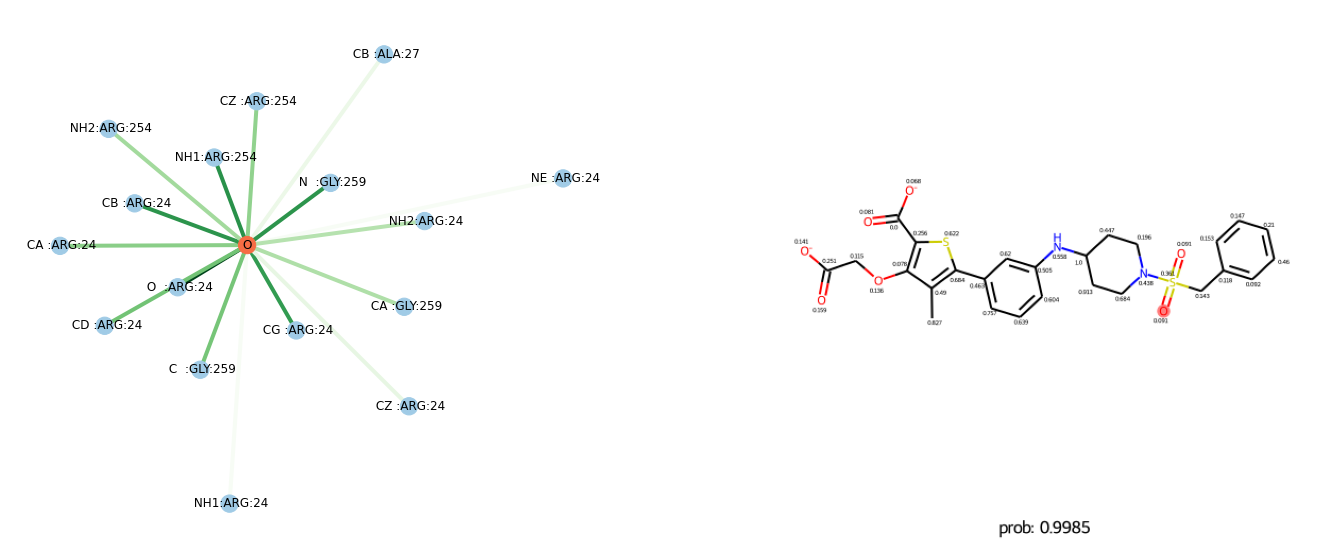

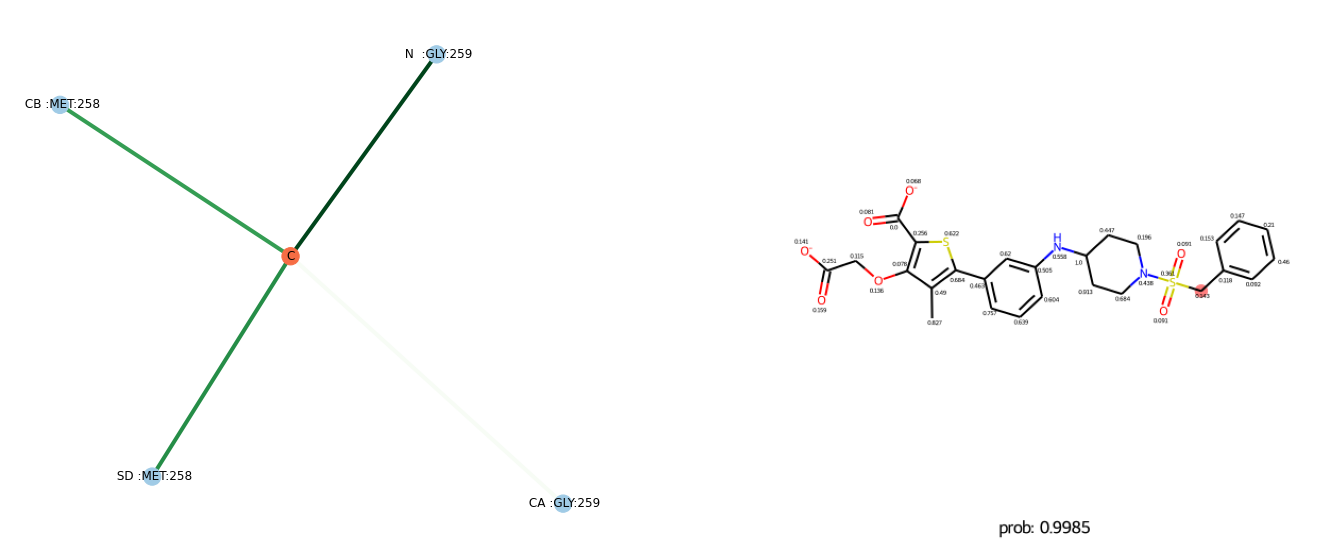

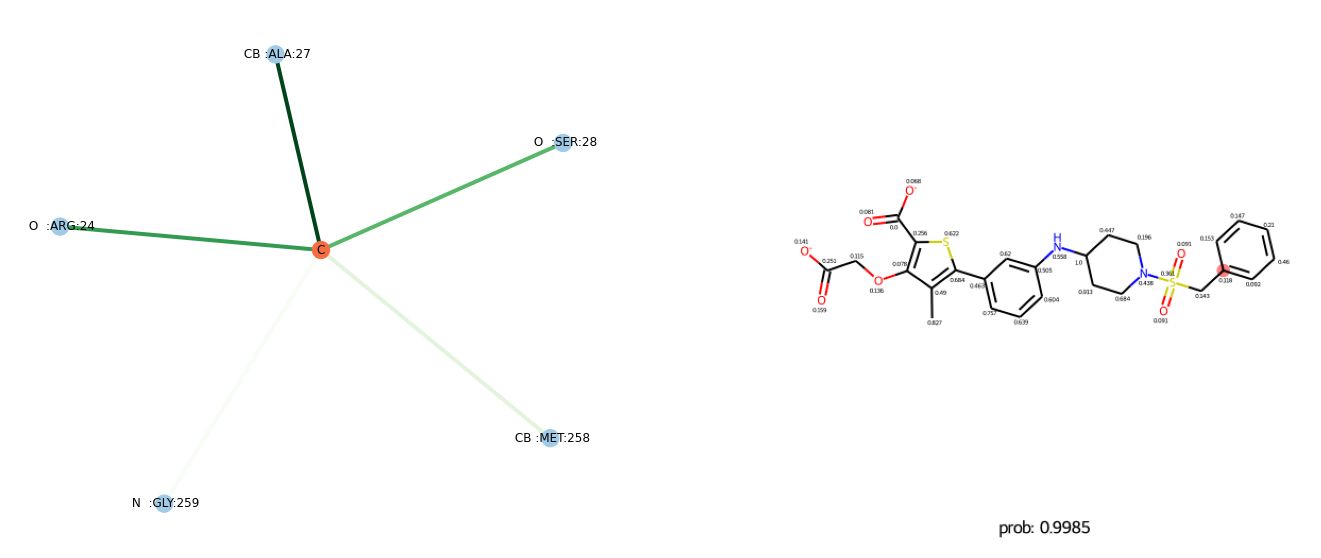

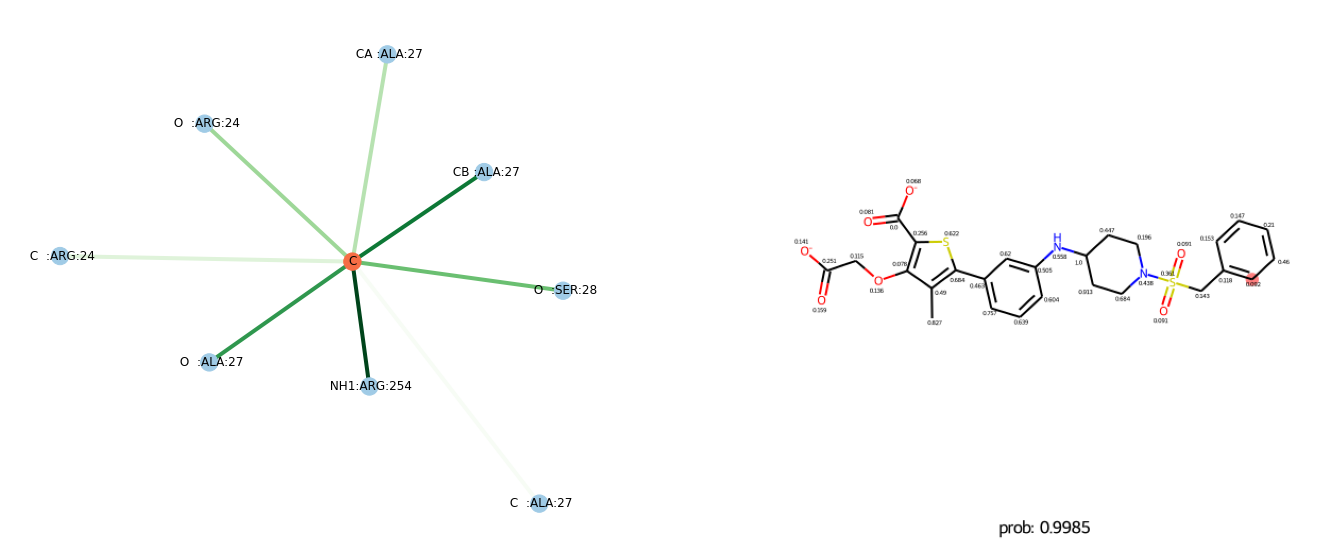

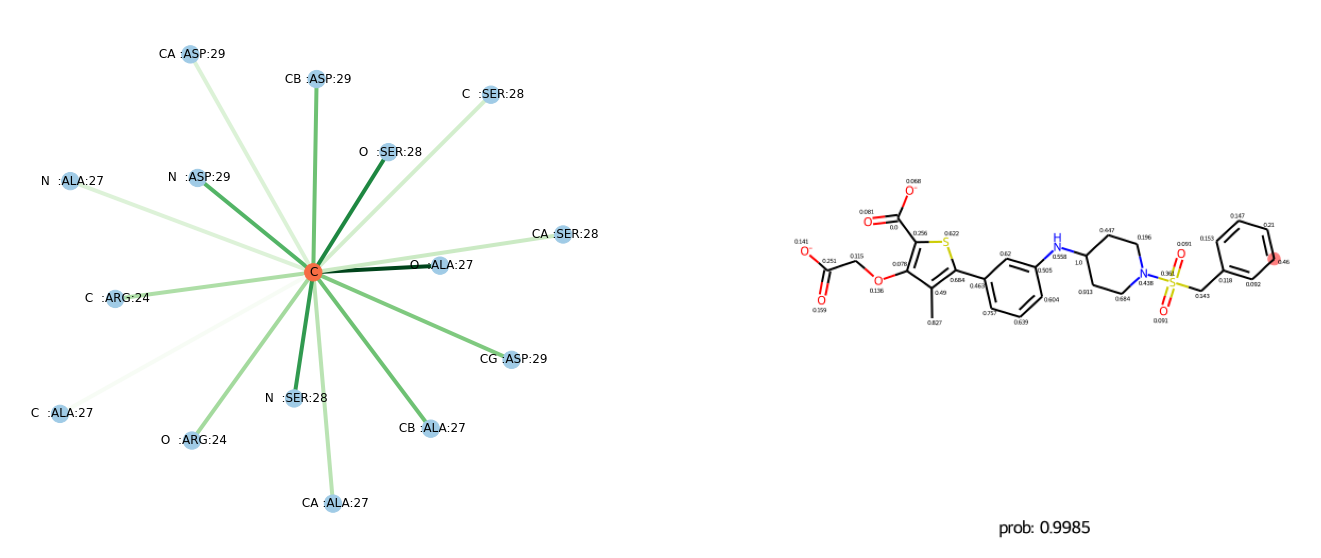

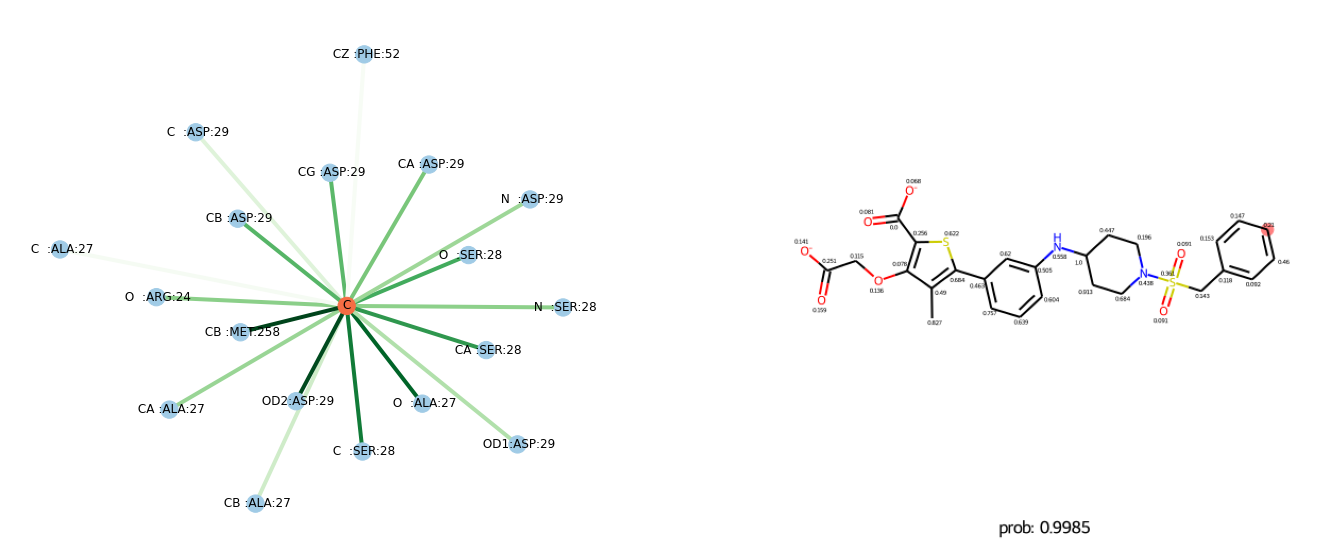

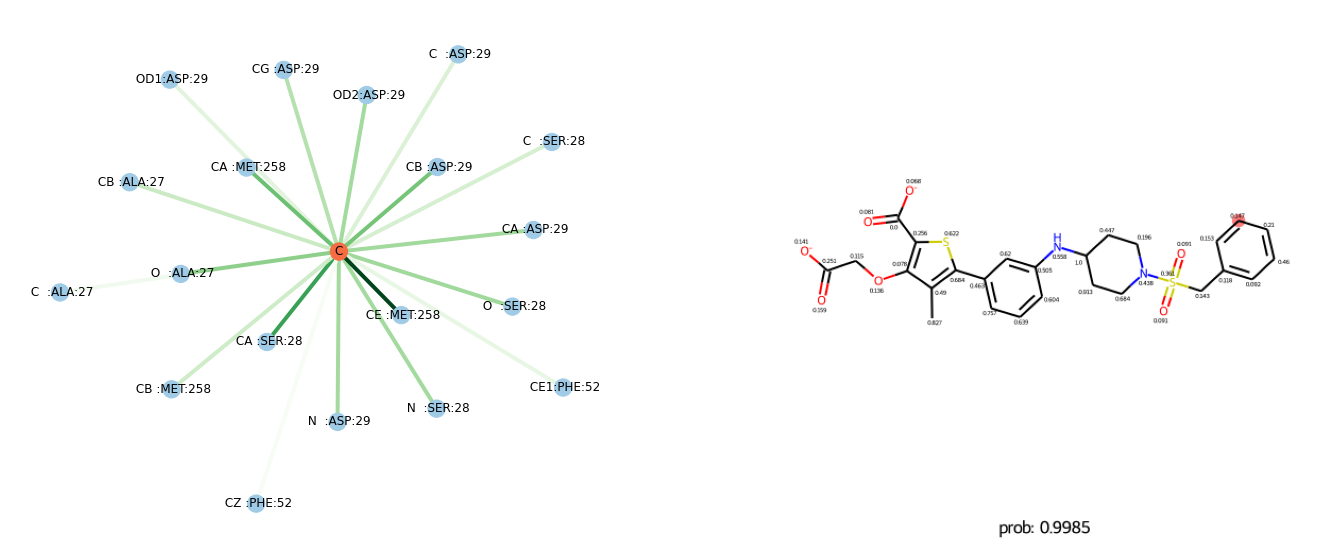

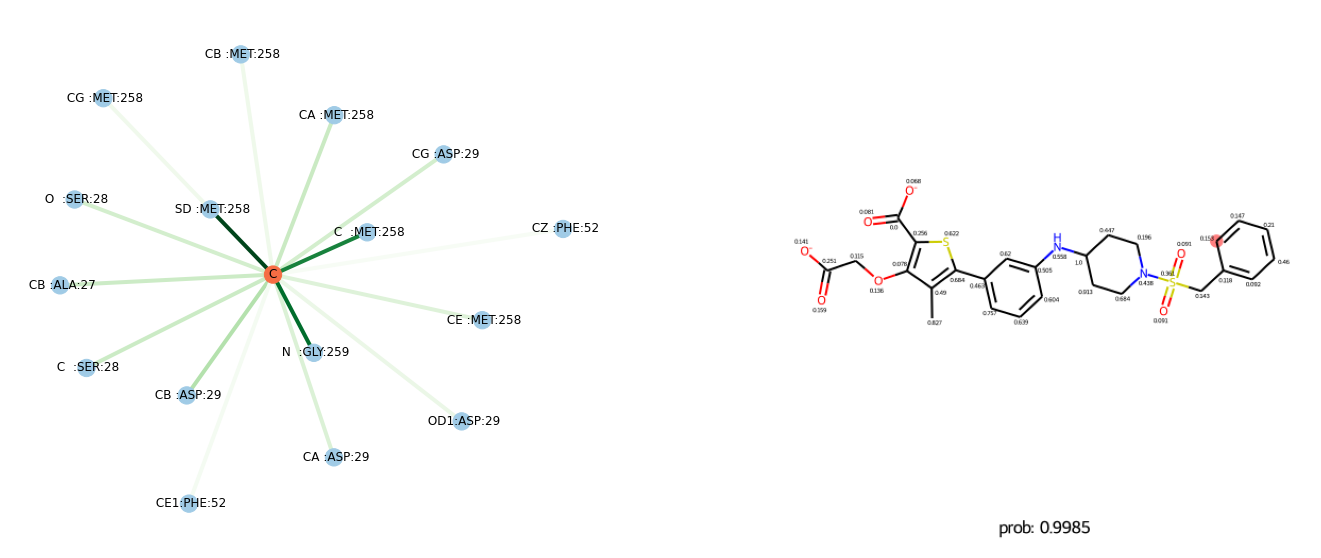

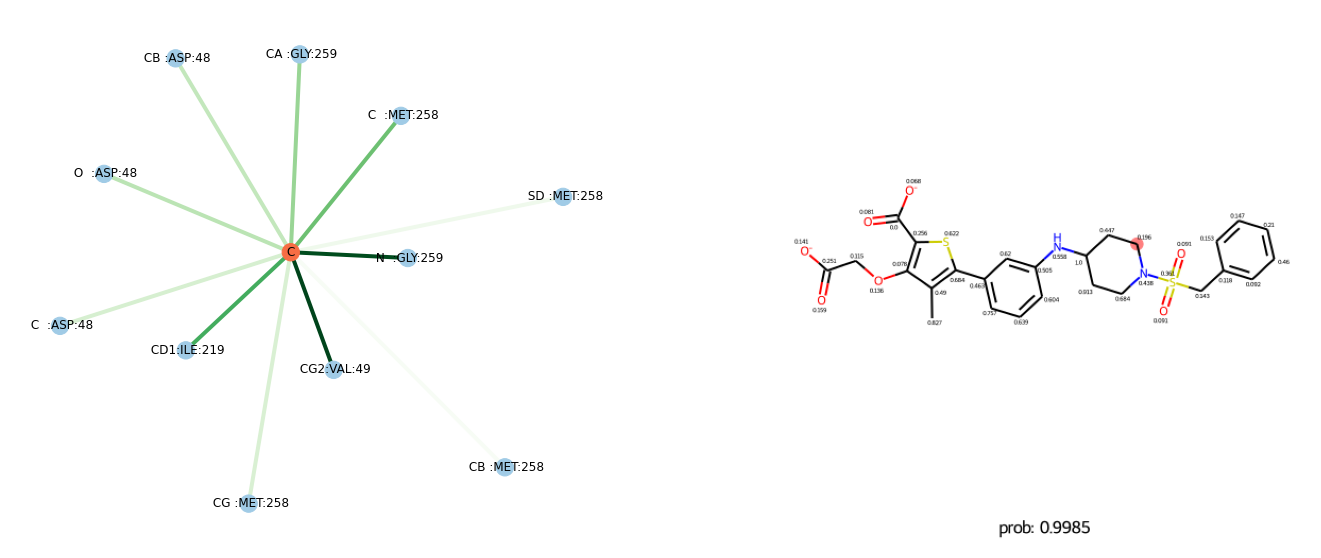

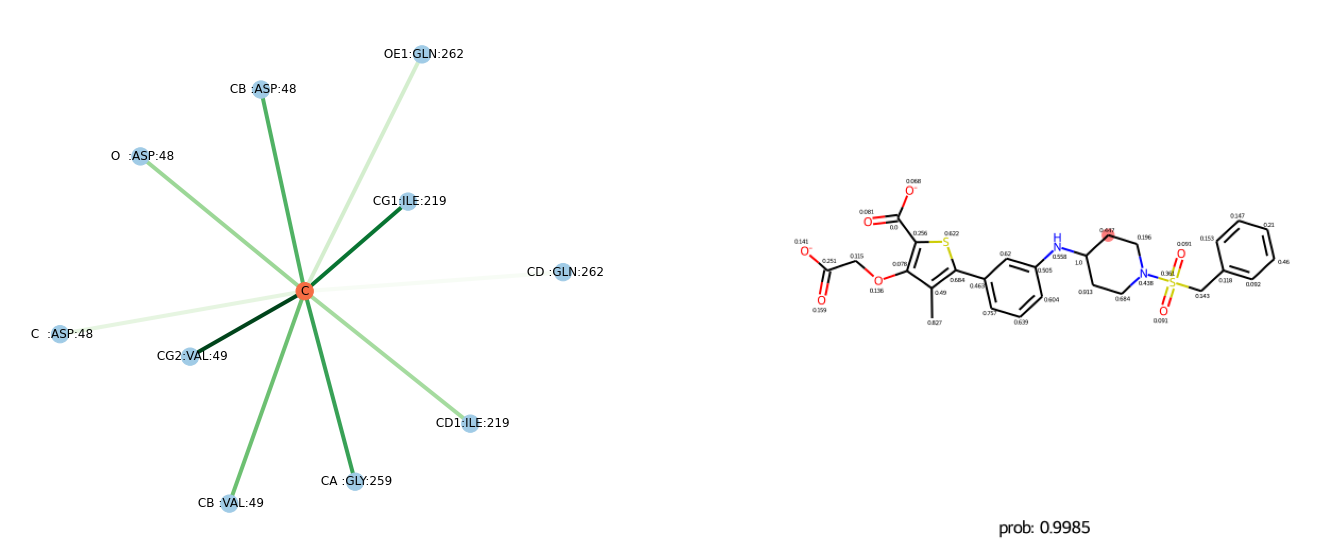

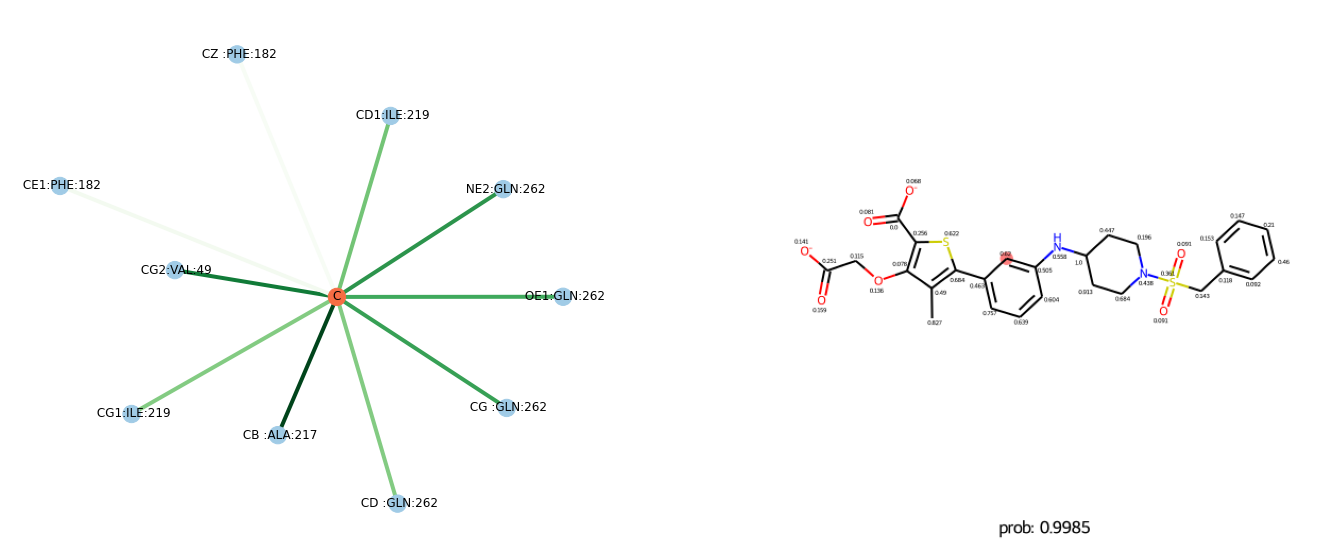

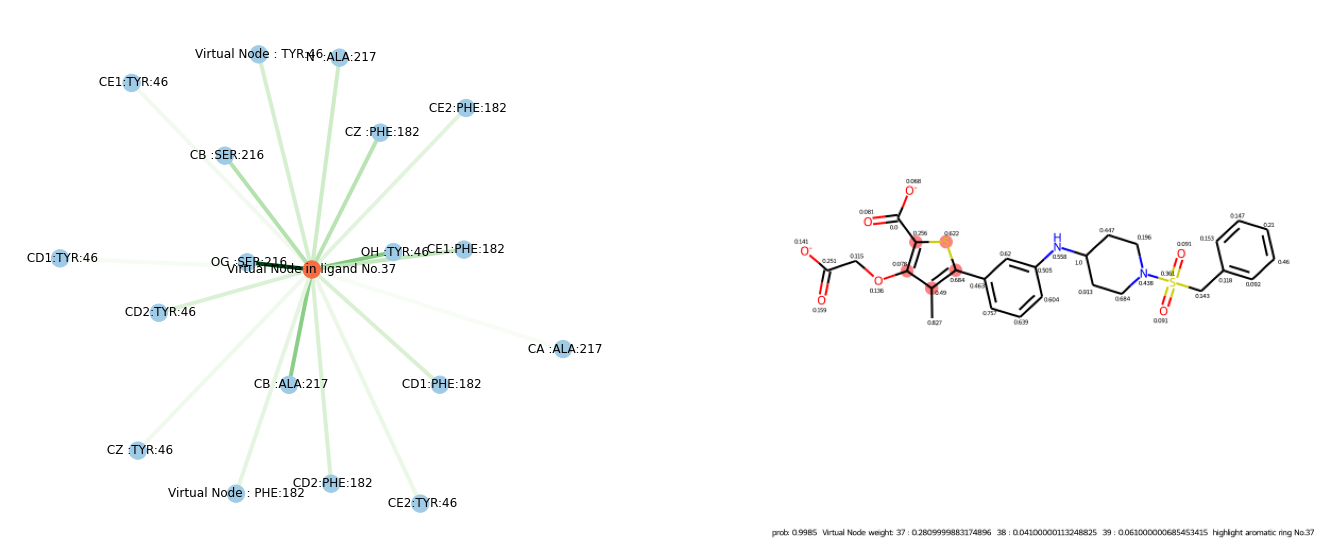

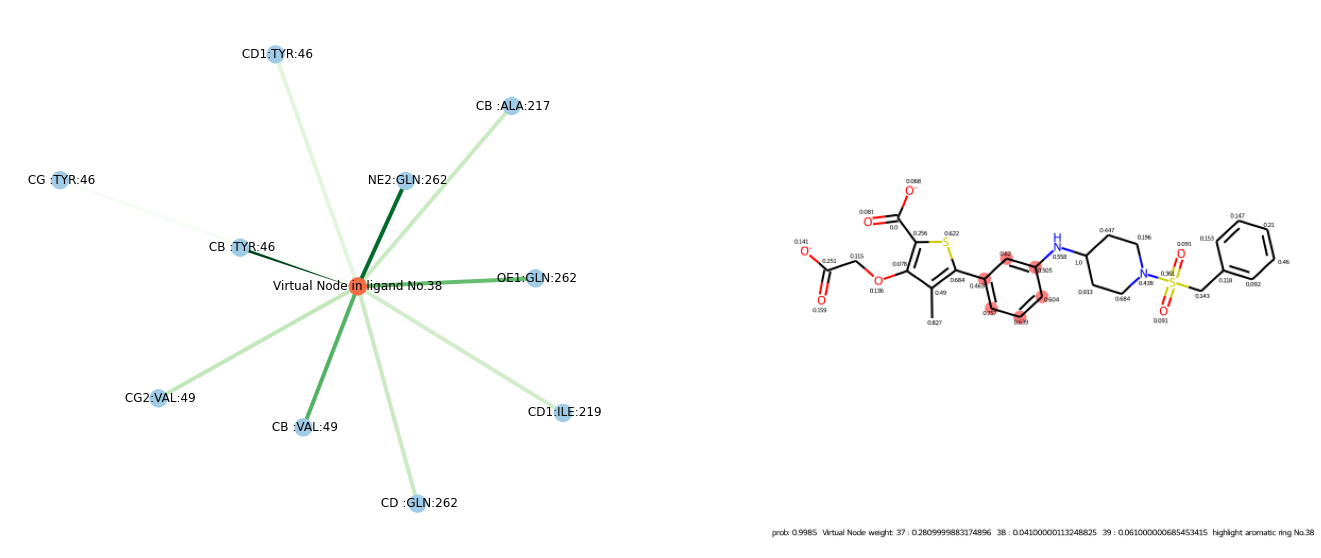

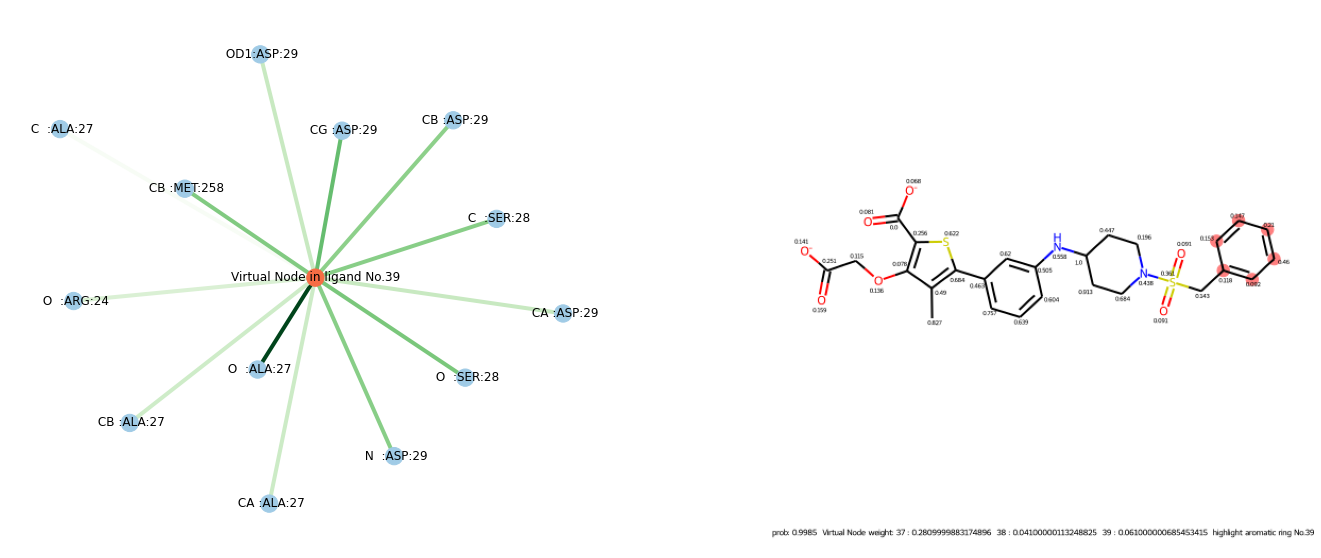

In [12]:

add_label = True # set to plot a without label star plot
merge_image_dir = './figures/fep1_atom_interaction_weight_merge/'
for logit,g,key in zip(logits,gs,test_keys):
    logit = F.softmax(logit,dim = 1)[:,1].data.cpu().numpy()[0]
    if logit > 0.0:
        all_atom_ligand = g[0].ndata['V'].sum().cpu().data.numpy()
        true_atom_ligand = len(g[2].GetAtoms())
        true_atom_pocket = len(g[3].GetAtoms())
        inchi_to_mol,mol_to_inchi = InchMap(g[2])
        mol = Chem.MolFromSmiles(Chem.MolToSmiles(g[2]))
        inchi_smiles_to_mol,mol_smiles_to_inchi  = InchMap(mol)

        ligand = g[2]
        pocket = g[3]
        for idx in range(int(all_atom_ligand)):
            G = nx.Graph()
            if idx < true_atom_ligand:
                ligand_atom = ligand.GetAtomWithIdx(idx).GetSymbol()
            else:
                ligand_atom = f'Virtual Node in ligand No.{idx}'
            G.add_nodes_from([ligand_atom])
            src,dst = g[1].in_edges(torch.tensor([idx]).to('cuda:0'))
            eid = g[1].edge_ids(src,dst)
            data_raw = g[1].edata['score'][eid].cpu().data.numpy()
            data_raw = data_raw.sum(1).flatten()/8
            for weight_idx,src_idx in enumerate(src):
                if src_idx.cpu().data.numpy() >= all_atom_ligand:
                    src_idx = int(src_idx.cpu().data.numpy() - all_atom_ligand)
                    # print(src_idx)
                    if src_idx <true_atom_pocket:
                        atom_pocket,residual_name,residual_num = pocket.GetAtomWithIdx(src_idx).GetPDBResidueInfo().GetName(),\
                        pocket.GetAtomWithIdx(src_idx).GetPDBResidueInfo().GetResidueName(),pocket.GetAtomWithIdx(src_idx).GetPDBResidueInfo().GetResidueNumber()
                        pocket_info = atom_pocket+ ':' + residual_name +':'+ str(residual_num)
                    else:
                        negs = g[0].in_edges(src_idx + int(all_atom_ligand))[0].data.cpu().numpy().tolist()
                        negs = [i - int(all_atom_ligand) for i in negs if i !=idx]
                        residual_name,residual_num = \
                        pocket.GetAtomWithIdx(negs[0]).GetPDBResidueInfo().GetResidueName(),pocket.GetAtomWithIdx(negs[0]).GetPDBResidueInfo().GetResidueNumber()
                        pocket_info = residual_name +':'+ str(residual_num)
                        pocket_info = 'Virtual Node : ' + pocket_info
                    G.add_node(pocket_info)
                    G.add_edge(ligand_atom,pocket_info,weight = data_raw[weight_idx])
            merge_save_path = os.path.join(*[merge_image_dir,os.path.join(*key.split('/')[-2:-1])])
            # print(merge_save_path)
            save_path = os.path.join(*[save_dir,os.path.join(*key.split('/')[-2:-1])])
            os.makedirs(merge_save_path, exist_ok=True)
            if idx < true_atom_ligand:
                inchi_idx = inchi_smiles_to_mol[mol_to_inchi[idx]]
                weightmap_dir = os.path.join(save_path,key.split('/')[-1] + '_atom_idx_{}_{}.png'.format(inchi_idx,'%.4f'%logit))
                pltStarWeightMap(G,weightmap_dir,merge_save_path,with_labels=add_label)
            else:
                weightmap_dir = os.path.join(save_path,key.split('/')[-1] +'_virtual_node_{}_{}.png'.format(idx,'%.4f'%logit))
                pltStarWeightMap(G,weightmap_dir,merge_save_path,with_labels=add_label)